![A soccer pitch for an international match.](soccer-pitch.jpg)

Suponha que eu trabalhe como jornalista esportivo em uma grande empresa de mídia esportiva on-line, especializada em análises e reportagens de futebol. E que há vários anos que assisto a jogos internacionais de futebol masculino e feminino, então meu instinto me diz que são marcados mais gols nos jogos internacionais de futebol feminino do que nos masculinos.

Ao definir o escopo deste projeto, reconheço que o esporte mudou muito ao longo dos anos e que os desempenhos provavelmente variam muito dependendo do torneio, portanto, para limitar os dados usados ​​na análise apenas aos jogos oficiais da "Copa do Mundo da FIFA" (não incluindo eliminatórias) desde `2002-01-01`.

Eu coleto dois conjuntos de dados contendo os resultados de todas as partidas oficiais de futebol internacional masculino e feminino desde o século 19. Esses dados são armazenados em dois arquivos CSV: `women_results.csv` e `men_results.csv`.

A pergunta para a qual estamos tentando determinar a resposta é:

> São marcados mais gols em partidas internacionais de futebol feminino do que em partidas masculinas?

Vamos assumir um **nível de significância de 10%** e usar as seguintes hipóteses nulas e alternativas:

$H_0$ : O número médio de gols marcados em partidas internacionais de futebol feminino é igual ao masculino.

$H_A$ : A média de gols marcados em partidas internacionais de futebol feminino é maior que a masculina.

In [1]:
# Importing Libraries for Cleaning and Exploration

import pandas as pd
import seaborn as sns

In [2]:
men_results = pd.read_csv("men_results.csv")
men_results.head()

,Unnamed: 0,date,home_team,away_team,home_score,away_score,tournament
0,0,1872-11-30,Scotland,England,0,0,Friendly
1,1,1873-03-08,England,Scotland,4,2,Friendly
2,2,1874-03-07,Scotland,England,2,1,Friendly
3,3,1875-03-06,England,Scotland,2,2,Friendly
4,4,1876-03-04,Scotland,England,3,0,Friendly


In [3]:
women_results = pd.read_csv("women_results.csv")
women_results.head()

,Unnamed: 0,date,home_team,away_team,home_score,away_score,tournament
0,0,1969-11-01,Italy,France,1,0,Euro
1,1,1969-11-01,Denmark,England,4,3,Euro
2,2,1969-11-02,England,France,2,0,Euro
3,3,1969-11-02,Italy,Denmark,3,1,Euro
4,4,1975-08-25,Thailand,Australia,3,2,AFC Championship


In [4]:
women_results.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4884 entries, 0 to 4883
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  4884 non-null   int64 
 1   date        4884 non-null   object
 2   home_team   4884 non-null   object
 3   away_team   4884 non-null   object
 4   home_score  4884 non-null   int64 
 5   away_score  4884 non-null   int64 
 6   tournament  4884 non-null   object
dtypes: int64(3), object(4)
memory usage: 267.2+ KB


In [5]:
# Function to ajust both dataframes

def ajust_results(results, gender):
    '''
    Simple function that subset the dates, FIFA chinpionship,
    sum of scores for both teams and create a gender column.
    Since were not using the whole dataframe cleanning only this
    part should be enough
    
    Input
        results: Pandas DataFrame
        gender: String
    Output
        results: Pandas DataFrame
    ''' 
    
    # convertion of date columns to an apropriate datatype
    results['date'] = pd.to_datetime(results['date'])
    
    # subsetting dates after 2002 
    is_date_after_equal_2002 = results['date'] >= pd.to_datetime("2002-01-01")
    results = results[is_date_after_equal_2002]
    
    # subsetting kind of tournment
    is_fifa_world_cup = results["tournament"].isin(["FIFA World Cup"])
    results = results[is_fifa_world_cup]
       
    # creates a column whi the total of scores in one match
    results['qtt_goals'] = results['away_score'] + results['home_score']
    
    # assign the gender to the results
    results['team_gender'] = gender
    
    return results

women_results = ajust_results(women_results, "women")
men_results = ajust_results(men_results, "men")

women_results['date'].describe()

count                     200
unique                     84
top       2003-09-20 00:00:00
freq                        4
first     2003-09-20 00:00:00
last      2019-07-07 00:00:00
Name: date, dtype: object

In [6]:
# Unite women and men data
all_results = pd.concat(
    [men_results[['qtt_goals', 'team_gender']], women_results[['qtt_goals', 'team_gender']]],
    ignore_index= True
)

# Show mean of goals for each gender
all_results.groupby("team_gender")["qtt_goals"].mean()

team_gender
men      2.513021
women    2.980000
Name: qtt_goals, dtype: float64

<AxesSubplot: xlabel='qtt_goals'>

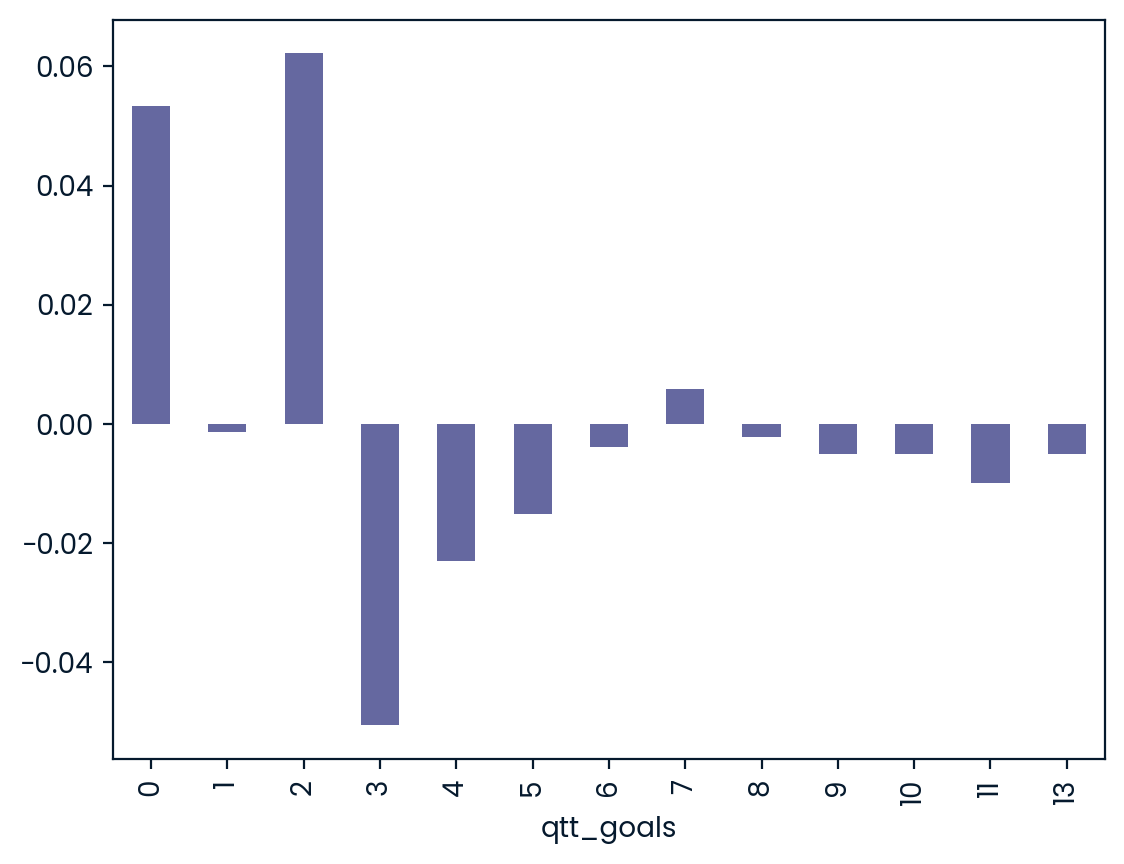

In [7]:
# Cross the quantity of scores by gender and normalize the count
cross_results = pd.crosstab(all_results["qtt_goals"], all_results["team_gender"],
                            normalize= "columns")

# New table with the differences of socres
relat_diff_results = cross_results['men'] - cross_results['women']

# Graph of relative differences by total of scores
relat_diff_results.plot(kind= "bar")

In [8]:
# checking sample requisites 

# 1. Independence and identicaly distributed was supposed in the beguining

In [9]:
# 2. There is enough samples by group?

all_results.groupby("team_gender")["qtt_goals"].count() >= 30

team_gender
men      True
women    True
Name: qtt_goals, dtype: bool

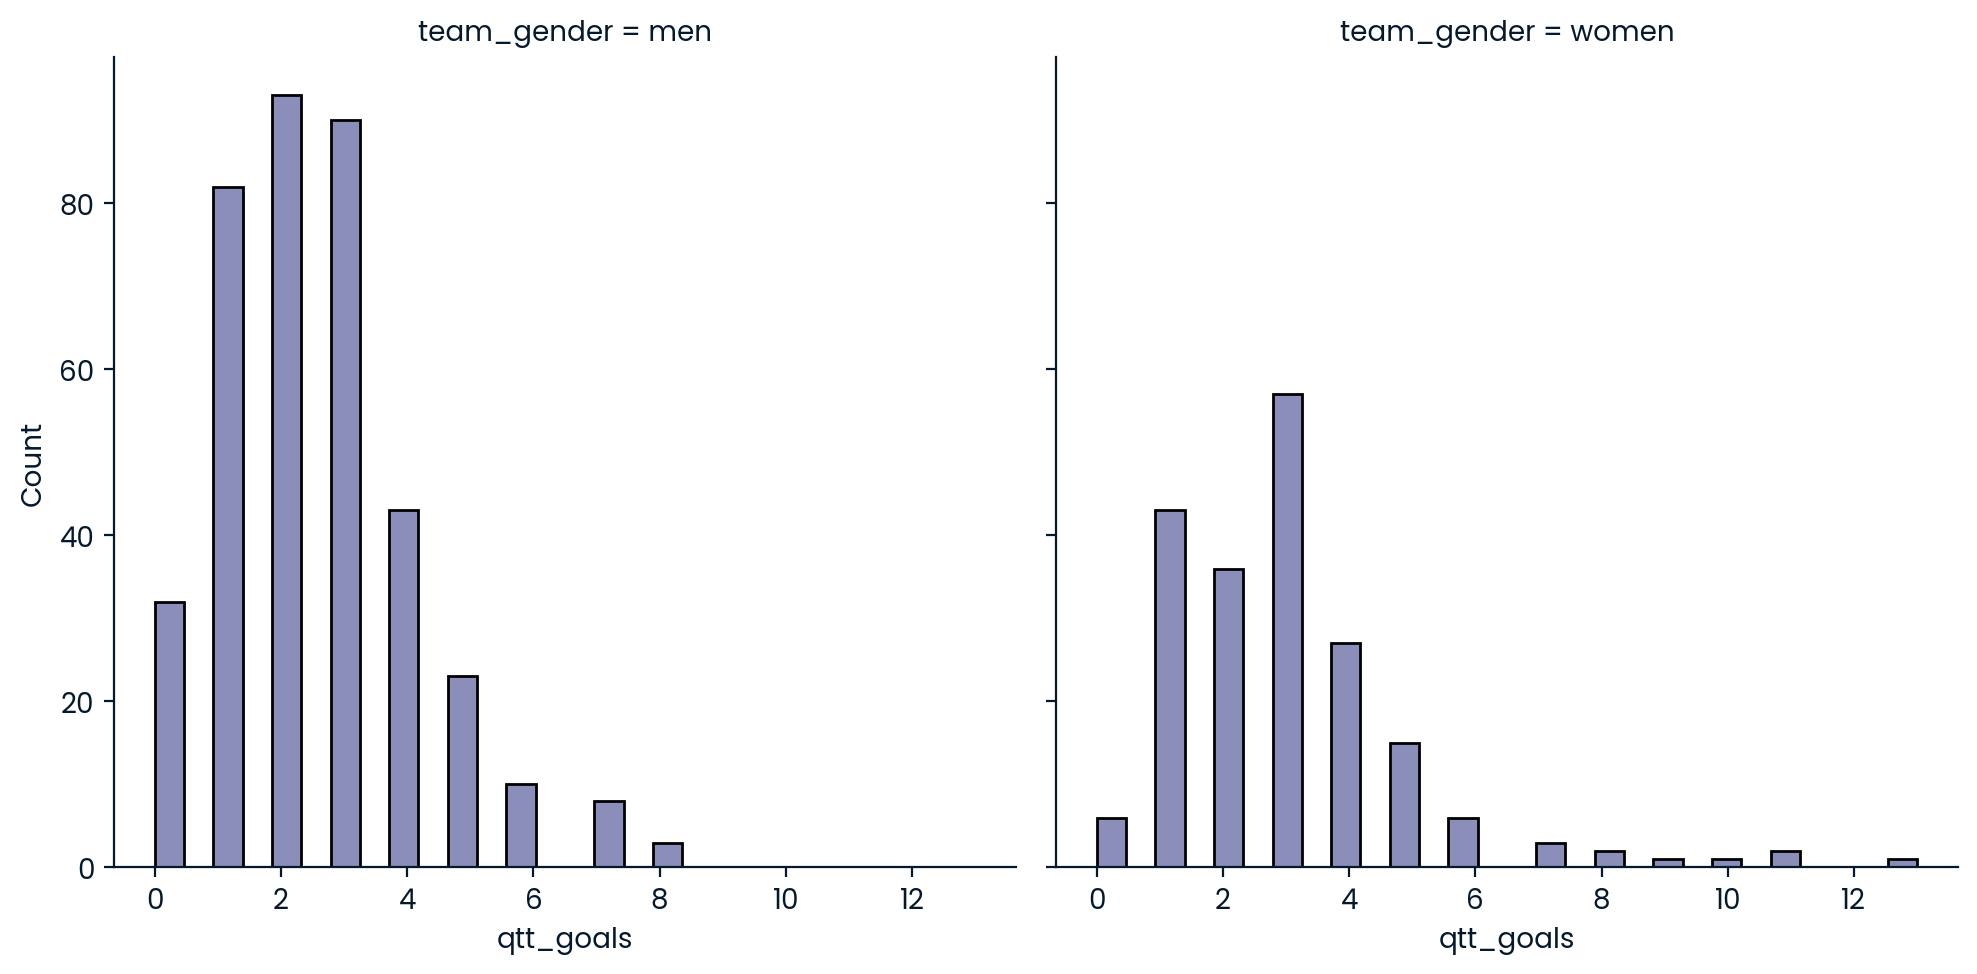

In [10]:
# 3. Normally distributed

sns.displot(data= all_results, kind= "hist", x= "qtt_goals", col= 'team_gender')

In [11]:
# Not normally distributed :'(

import pingouin
from scipy.stats import mannwhitneyu

In [12]:
# Wilcoxon-Mann-Whitney test

alpha = 0.01

results_subset_wide = all_results.pivot(columns="team_gender", values="qtt_goals")

results_pg = pingouin.mwu(x=results_subset_wide["women"],
                          y=results_subset_wide["men"],
                          alternative="greater")

results_scipy = mannwhitneyu(x=women_results["qtt_goals"],
                             y=men_results["qtt_goals"],
                             alternative="greater")

results_pg

,U-val,alternative,p-val,RBC,CLES
MWU,43273.0,greater,0.005107,-0.126901,0.563451


In [16]:
# What we should do with the null hypothesis?

p_val = results_pg["p-val"].values[0]

if p_val <= alpha:
    result = "reject"
else:
    result = "fail to reject"

result

'reject'

Seen that the p-value is lower than the significance level previously defined, we **reject** the null hypothesis, and by that we conclude that the number of scores in FIFA official football matches is **not the same** for women and man.

In [17]:
result_dict = {"p_val": p_val, "result": result}
result_dict

{'p_val': 0.005106609825443641, 'result': 'reject'}